In [104]:
import pandas as pd
import seaborn as sbn
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import precision_score, recall_score, make_scorer # precision: ketika benar, maka berapa persentase benar. recall: banyak data yang kena

In [105]:
df = pd.read_csv("ds_salaries.csv")
"""
Beberapa Notes untuk Kolom dataset tersebut adalah: 
1. work_year: Tahun dimana gajinya telah diberikan
2. experience_level: level experience / pengalaman dalam bidang pekerjaan
    field_value: {
        EN: Entry level                 1
        MI: Junior Mid Level            2
        SE: Intermediate Senior Level   3
        EX: Expert Executive Level      4
    }
3. employement_type: Tipe pekerja
    field_value: {
        PT: kerja paruh waktu           4
        FT: kerja fulltime              3
        CT: contract                    2
        FL: Freelance                   1
}
4. job_title: Job Title
5. salary: nilai gaji
6. salary_currency: nilai gaji tersebut dalam mata uang apa
7. salary_in_usd: gaji jika di ubah menjadi mata uang dollar
8. employee_residence: lokasi asal dari pekerja
9. remote_ratio: rasio pekerja bekerja secara jarak jauh
10. company_location: lokasi perusahaan pekerja
11. company_size: ukuran dari perusahaan berdasarkan dari jumlah pekerja di sana
    field_value{
        S: small (x<50),
        M: medium (50<=x<250),
        L: large (x>250),
}
"""


df = pd.read_csv("ds_salaries.csv")
df

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,1
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,1
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,1
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,1
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M,1
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M,1
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M,1
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M,1


Menghapus Outlier

In [106]:

q1 = df["salary_in_usd"].quantile(0.25) # Quartile 1
q3 = df["salary_in_usd"].quantile(0.75) # Quartile 3
iqr = q3-q1 # Inter Quartile Range

low_lim = q1 - 1.5*iqr
hi_lim = q3 + 1.5*iqr

print(f"{low_lim}, {hi_lim}")

for i in range(len(df["salary_in_usd"])):
    if hi_lim < df["salary_in_usd"][i]:
        df = df.drop([i])

df = df.reset_index()

q1 = df["salary"].quantile(0.25) # Quartile 1
q3 = df["salary"].quantile(0.75) # Quartile 3
iqr = q3-q1 # Inter Quartile Range

low_lim = q1 - 1.5*iqr
hi_lim = q3 + 1.5*iqr

print(f"{low_lim}, {hi_lim}")

for i in range(len(df["salary"])):
    if hi_lim < df["salary"][i]:
        df = df.drop([i])
df = df.reset_index()

df["company_size"] = df["company_size"].apply(lambda x: 1 if x == "S" else x)
df["company_size"] = df["company_size"].apply(lambda x: 2 if x == "M" else x)
df["company_size"] = df["company_size"].apply(lambda x: 3 if x == "L" else x)



df["experience_level"] = df["experience_level"].apply(lambda x: 1 if x == "EN" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 2 if x == "MI" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 3 if x == "SE" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 4 if x == "EX" else x)

df["employment_type"] = df["employment_type"].apply(lambda x: 4 if x == "FT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 3 if x == "PT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 2 if x == "CT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 1 if x == "FL" else x)

-68185.0, 280911.0
-65002.5, 295001.5


<Axes: >

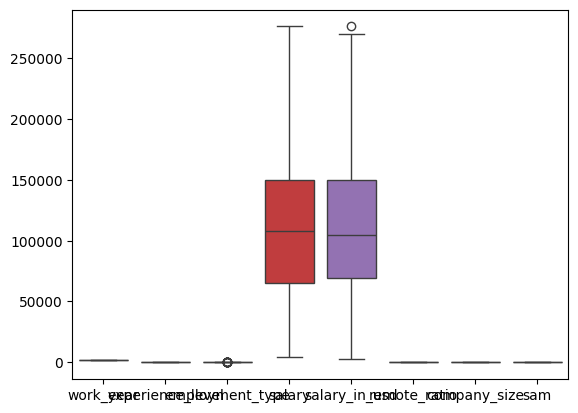

In [107]:
df = df.drop(columns=["level_0", "index", "Unnamed: 0"])
sbn.boxplot(data=df)

<Axes: xlabel='experience_level', ylabel='salary_in_usd'>

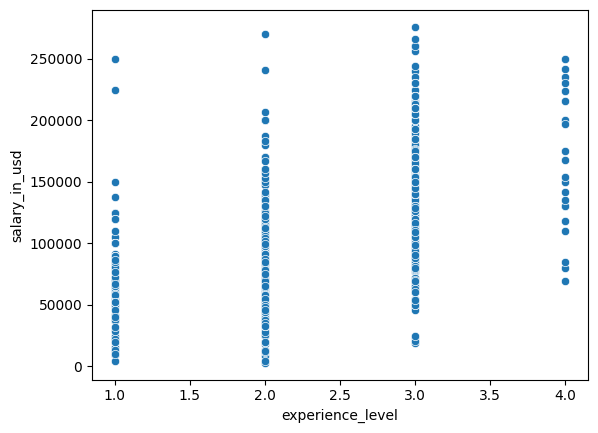

In [108]:
sbn.scatterplot(data=df, y= df["salary_in_usd"], x=df["experience_level"])

In [109]:
df.reset_index()

,index,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,0,2020,2,4,Data Scientist,70000,EUR,79833,DE,0,DE,3,1
1,1,2020,3,4,Machine Learning Scientist,260000,USD,260000,JP,0,JP,1,1
2,2,2020,3,4,Big Data Engineer,85000,GBP,109024,GB,50,GB,2,1
3,3,2020,2,4,Product Data Analyst,20000,USD,20000,HN,0,HN,1,1
4,4,2020,3,4,Machine Learning Engineer,150000,USD,150000,US,50,US,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,556,2022,3,4,Data Engineer,154000,USD,154000,US,100,US,2,1
557,557,2022,3,4,Data Engineer,126000,USD,126000,US,100,US,2,1
558,558,2022,3,4,Data Analyst,129000,USD,129000,US,0,US,2,1
559,559,2022,3,4,Data Analyst,150000,USD,150000,US,100,US,2,1


In [110]:
df.describe()

,work_year,experience_level,employment_type,salary,salary_in_usd,remote_ratio,company_size,sam
count,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.0
mean,2021.447415,2.422460,3.948307,112440.358289,111965.424242,71.568627,2.180036,1.0
std,0.679678,0.768669,0.325963,58419.459966,56881.438715,40.730377,0.636419,0.0
min,2020.000000,1.000000,1.000000,4000.000000,2859.000000,0.000000,1.000000,1.0
25%,2021.000000,2.000000,4.000000,65000.000000,69336.000000,50.000000,2.000000,1.0
50%,2022.000000,3.000000,4.000000,108000.000000,105000.000000,100.000000,2.000000,1.0
75%,2022.000000,3.000000,4.000000,150075.000000,150000.000000,100.000000,3.000000,1.0
max,2022.000000,4.000000,4.000000,276000.000000,276000.000000,100.000000,3.000000,1.0


In [111]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,2020,2,4,Data Scientist,70000,EUR,79833,DE,0,DE,3,1
1,2020,3,4,Machine Learning Scientist,260000,USD,260000,JP,0,JP,1,1
2,2020,3,4,Big Data Engineer,85000,GBP,109024,GB,50,GB,2,1
3,2020,2,4,Product Data Analyst,20000,USD,20000,HN,0,HN,1,1
4,2020,3,4,Machine Learning Engineer,150000,USD,150000,US,50,US,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
556,2022,3,4,Data Engineer,154000,USD,154000,US,100,US,2,1
557,2022,3,4,Data Engineer,126000,USD,126000,US,100,US,2,1
558,2022,3,4,Data Analyst,129000,USD,129000,US,0,US,2,1
559,2022,3,4,Data Analyst,150000,USD,150000,US,100,US,2,1


# Memisah data Untuk Train dan Test
1. Bentuk pandas DataFrame

In [112]:
def ratio_split(nil, data):
    """Masukkan Nilai dalam bentuk puluhan, misal: 70"""
    for i in data:
        nilai = len(data[i])
        return round(nilai * (nil/100))
data_column = df.columns
print(data_column)

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'sam'],
      dtype='object')


In [113]:
def split_data(data, ratsplit:int, kolom) -> list:
    looping = 0
    looping_index = []
    test_index = []
    train_index = []
    test = []
    train = []
    for i in data:
        for j in range(len(data[i])):
            while True:
                randomval = random.randint(0, len(data[i])- 1)
                if randomval not in looping_index:
                    if looping <= ratsplit:
                        train_index.append(randomval)
                        looping_index.append(randomval)
                        looping += 1
                        break
                    else:
                        test_index.append(randomval)
                        looping_index.append(randomval)
                        looping += 1
                        break
                else:
                    continue
        break
    print(train_index)
    print(test_index)
    for i in train_index:
        duta = []
        for j in data:
            duta.append(data[j][i])
        train.append(duta)
    
    for i in test_index:
        duta = []
        for j in data:
            duta.append(data[j][i])
        test.append(duta)
    
    train = pd.DataFrame(train, columns=kolom)
    test = pd.DataFrame(test, columns=kolom)

    return train, test

In [114]:
ratsplit = ratio_split(70, df)
training, testing = split_data(df, ratsplit, data_column)
print(len(training), len(testing))

[431, 71, 453, 139, 522, 365, 128, 344, 78, 466, 304, 206, 294, 361, 359, 390, 520, 58, 357, 501, 126, 31, 219, 514, 529, 119, 170, 99, 3, 266, 141, 360, 38, 394, 469, 273, 57, 451, 155, 527, 93, 506, 386, 331, 41, 546, 110, 457, 454, 368, 107, 36, 324, 100, 242, 489, 465, 452, 470, 32, 534, 343, 211, 505, 389, 92, 56, 232, 34, 333, 142, 541, 214, 315, 378, 18, 521, 44, 231, 140, 50, 112, 425, 270, 519, 265, 473, 321, 180, 230, 116, 303, 407, 513, 441, 8, 173, 459, 183, 306, 16, 28, 124, 381, 221, 405, 194, 182, 187, 80, 327, 458, 217, 557, 323, 320, 59, 175, 318, 96, 337, 185, 103, 117, 98, 7, 115, 488, 444, 478, 86, 73, 516, 495, 226, 168, 39, 477, 85, 353, 174, 131, 111, 335, 62, 313, 363, 498, 49, 146, 398, 53, 341, 257, 145, 397, 371, 547, 121, 551, 486, 255, 215, 189, 252, 54, 29, 122, 356, 410, 238, 4, 415, 391, 258, 409, 130, 192, 127, 417, 69, 109, 40, 334, 524, 274, 260, 349, 460, 525, 530, 222, 167, 493, 143, 237, 23, 336, 461, 81, 204, 275, 152, 358, 220, 1, 157, 70, 307, 5

In [115]:
training

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,2022,2,4,Data Scientist,140000,GBP,183228,GB,0,GB,2,1
1,2021,4,4,Director of Data Science,130000,EUR,153667,IT,100,PL,3,1
2,2022,3,4,Data Scientist,165000,USD,165000,US,100,US,2,1
3,2021,2,4,Data Engineer,24000,EUR,28369,MT,50,MT,3,1
4,2022,3,4,Data Analyst,80000,USD,80000,US,100,US,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
389,2021,3,4,Lead Data Engineer,75000,GBP,103160,GB,100,GB,1,1
390,2022,3,4,Analytics Engineer,184700,USD,184700,US,0,US,2,1
391,2022,2,4,Data Analyst,167000,USD,167000,US,100,US,2,1
392,2022,3,4,Data Engineer,210000,USD,210000,US,100,US,2,1


In [116]:
testing

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,2022,2,4,Applied Machine Learning Scientist,75000,USD,75000,BO,100,US,3,1
1,2022,3,4,Principal Data Scientist,148000,EUR,162674,DE,100,DE,2,1
2,2022,3,4,Data Scientist,104890,USD,104890,US,100,US,2,1
3,2020,2,4,Machine Learning Infrastructure Engineer,44000,EUR,50180,PT,0,PT,2,1
4,2022,3,4,Data Analyst,109280,USD,109280,US,100,US,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
162,2022,2,4,Business Data Analyst,90000,CAD,70912,CA,50,CA,3,1
163,2022,3,4,Data Engineer,183600,USD,183600,US,100,US,3,1
164,2022,2,4,Data Scientist,160000,USD,160000,US,100,US,2,1
165,2022,2,4,Data Analyst,58000,USD,58000,US,0,US,1,1


2. Bentuk  Np. Array

# Implementasi ke dalam Machine Learning
1. Model Random Forest

In [117]:
arr = np.array([df["job_title"]]).reshape(-1,1)
print(arr.shape)
enco = OneHotEncoder(sparse_output=False)
y = enco.fit_transform(arr)

(561, 1)


In [118]:
x = df.drop(columns=["job_title", "salary", "salary_currency", "employee_residence", "company_location"]).values
print(f"x: {x.shape}, y: {y.shape}")
print(x)
print(y)

x: (561, 7), y: (561, 47)
[[2020    2    4 ...    0    3    1]
 [2020    3    4 ...    0    1    1]
 [2020    3    4 ...   50    2    1]
 ...
 [2022    3    4 ...    0    2    1]
 [2022    3    4 ...  100    2    1]
 [2022    2    4 ...  100    3    1]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [119]:
pipa = Pipeline([
    ("scale", StandardScaler()),
    ("model", KNeighborsRegressor())
])
pipa.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler()), ('model', KNeighborsRegressor())],
 'verbose': False,
 'scale': StandardScaler(),
 'model': KNeighborsRegressor(),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'model__algorithm': 'auto',
 'model__leaf_size': 30,
 'model__metric': 'minkowski',
 'model__metric_params': None,
 'model__n_jobs': None,
 'model__n_neighbors': 5,
 'model__p': 2,
 'model__weights': 'uniform'}

In [120]:
moduel = GridSearchCV(
    estimator=pipa,
    param_grid={"model__n_neighbors": [0,1,2,3,4,5,6]},
    cv=6,
    n_jobs=-1
)

In [121]:
moduel.fit(x,y)

c:\Users\Nur Hary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 42.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nur Hary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nur Hary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nur H

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [0, 1, 2, 3, 4, 5, 6]})

In [122]:
pd.DataFrame(moduel.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001540,0.000575,0.000000,0.000000,0,{'model__n_neighbors': 0},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
1,0.002673,0.000640,0.001911,0.000844,1,{'model__n_neighbors': 1},-0.319358,-0.129069,-0.006792,0.656211,0.276026,0.419538,0.149426,0.333552,6
2,0.002375,0.000523,0.001795,0.000624,2,{'model__n_neighbors': 2},-0.023473,0.059148,-0.004406,0.618044,0.246366,0.510676,0.234392,0.250963,5
3,0.001947,0.000648,0.002158,0.000466,3,{'model__n_neighbors': 3},-0.020625,0.105705,0.038291,0.611625,0.234933,0.551438,0.253561,0.245176,1
4,0.002070,0.000616,0.001911,0.000395,4,{'model__n_neighbors': 4},0.011697,0.084763,0.029269,0.549267,0.221595,0.533577,0.238361,0.224642,2
5,0.002050,0.000355,0.002234,0.000702,5,{'model__n_neighbors': 5},0.037634,0.067035,0.056992,0.514593,0.237448,0.514567,0.238045,0.206209,3
6,0.002445,0.000333,0.001729,0.000541,6,{'model__n_neighbors': 6},0.051736,0.036851,0.078809,0.507755,0.217634,0.515430,0.234703,0.204361,4


In [123]:
xpred = moduel.predict(x)
print(xpred)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.33333333 0.         0.33333333 ... 0.         0.         0.        ]]


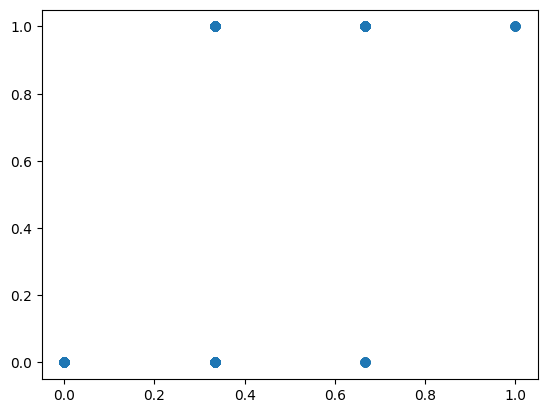

In [124]:
plt.scatter(xpred, y)